In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

cities = dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142));

coordinates = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531));


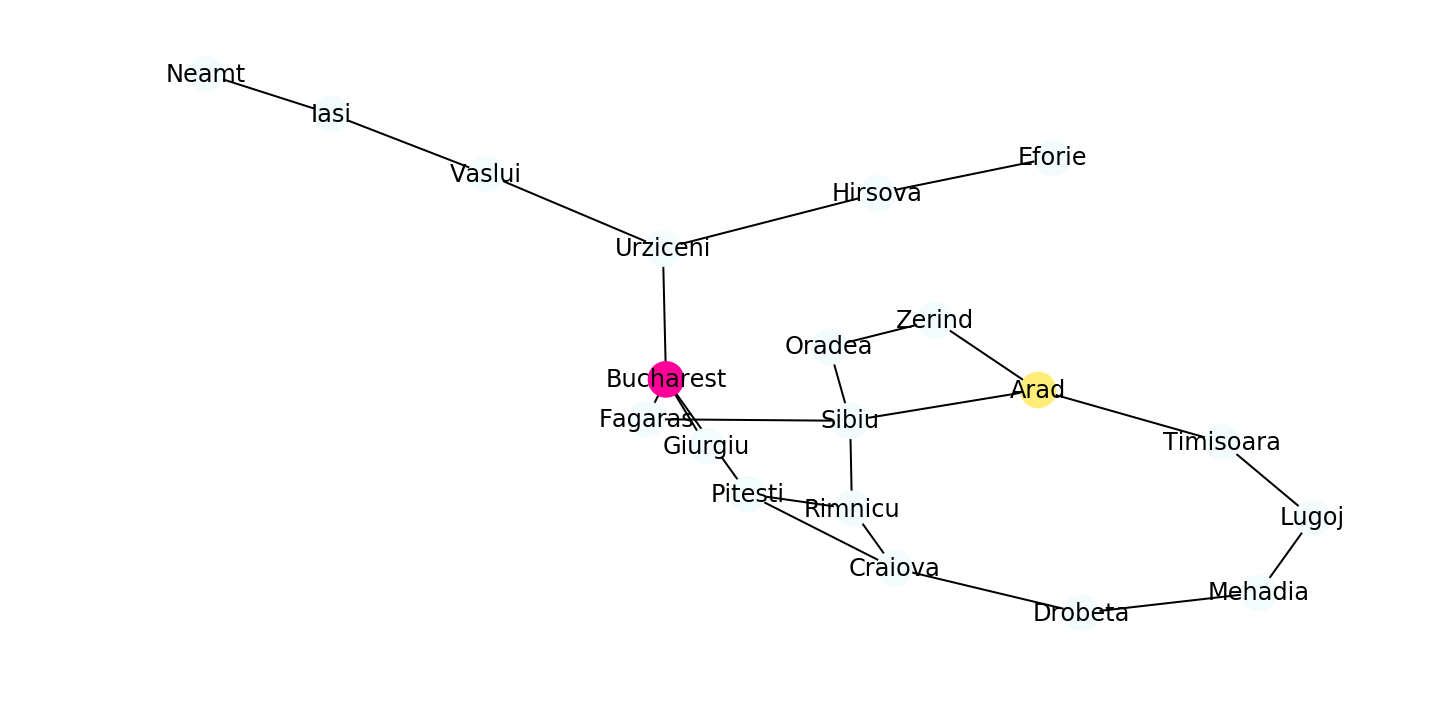

In [102]:
G = nx.Graph()

root = None;
goal = None;
cmap = {'neutral':'#f2fcfc', 'root':'#FFED79', 'goal':'#FF0099'}

def setRoot(label):
    color_map[list(G).index(label)] = cmap['root'];
    return G.node[label];

def setGoal(label):
    G.node[label]['isGoal'] = True;
    color_map[list(G).index(label)]= cmap['goal'];
    return G.node[label];

# one color for each node
color_map = [];

for nodeName, coordin in coordinates.items():
    G.add_node(nodeName, label=nodeName, coord=coordin, isGoal=False)
    color_map.append(cmap['neutral']);
for k,v in cities.items():
    for k1,v1 in v.items():
        G.add_edge(k,k1,cost=v1);
        
root = setRoot('Arad');
goal = setGoal('Bucharest');

plt.figure(figsize=(12,6))
nx.draw_networkx(G, node_size=300, node_color = color_map, with_labels = True);
plt.axis('off');


In [3]:
# g(n): path cost from s to n
def g(n):
    return
# h(n): estimated cheapest cost from n to a goal
# f(n) = g(n) + h(n)

open = []
closed = []

#nx.set_node_attributes(G,{'g':1}, None)

In [91]:
class node_wrapper:
    
    def __init__(self, node, parent=None):
        self.node = node;
        self.parent = parent;
        

In [113]:
# get childs of a node, if the node hasn't a parent childs == neighbours
def getChilds(n):
    childs = []
    label = n.node['label']
    for k,v in G.adj[label].items():
        if n.parent == None or k != n.parent.node['label']:
            node_w = node_wrapper(G.node[k])
            childs.append(node_w)
    return childs

# test
#p = node_wrapper(G.node['Sibiu'])
#n = node_wrapper(root,p)
#print(getChilds(n))

In [141]:
def pathFromRoot(node):
    path = ""
    if node.parent != None:
        path = pathFromRoot(node.parent);
    return path + " -> " + node.node['label'];

# test
#n = root
#p = node_wrapper(goal)
#x = node_wrapper(n,p)
#pathFromRoot(x)

In [144]:
# breadth first search

import time
class breadth_first:
    
    def __init__(self, graph, root, goal):
        
        self.open=[];
        self.close=[];
        
        self.open.append(node_wrapper(root))
        
        while (True):

            if self.open:
                # pop first from open and push it in closed
                n = self.open.pop(0);
                print('extracted: ' + n.node['label']);
                
                if n.parent != None:
                    print('(parent: '+n.parent.node['label']+')')
                    
                self.close.append(n);
            else:
                print('search failed');
                return;

            childs = getChilds(n)
            print('childs: ')

            for child in childs:
                
                print('> ' + child.node['label'])
                if child.parent != None:
                    print('>> (parent: '+child.parent.node['label']+')')
                
                x = node_wrapper(child.node,n)
                self.open.append(x);
                
                if child.node['isGoal']:
                    print('\n### Goal found ###');
                    print(pathFromRoot(x));
                    return;
                
                
breadth_first(G,root,goal)

extracted: Arad
childs: 
> Zerind
> Sibiu
> Timisoara
extracted: Zerind
(parent: Arad)
childs: 
> Oradea
extracted: Sibiu
(parent: Arad)
childs: 
> Fagaras
> Oradea
> Rimnicu
extracted: Timisoara
(parent: Arad)
childs: 
> Lugoj
extracted: Oradea
(parent: Zerind)
childs: 
> Sibiu
extracted: Fagaras
(parent: Sibiu)
childs: 
> Bucharest

### Goal found ###
 -> Arad -> Sibiu -> Fagaras -> Bucharest
